In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from datetime import datetime
from misc.utils import generate_generator, gen_imgPaths_and_labelPaths, monitor_mae, monitor_mse, \
                       sample_predictions, first_predictions, calc_mae_mse, get_profile
from sklearn.model_selection import train_test_split

from models import MCNN

%matplotlib inline
np.random.seed(123)

Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CrowdMask

In [3]:
train_img, train_labels, test_img, test_labels \
= (
    np.load('./npy/masks_train_img.npy'),
    np.load('./npy/masks_train_labels.npy'),
    np.load('./npy/masks_test_img.npy'),
    np.load('./npy/masks_test_labels.npy')
)

test_img, validation_img, test_labels, validation_labels = train_test_split(test_img, test_labels, test_size=0.5, random_state=24)

## Model trained on SHHB

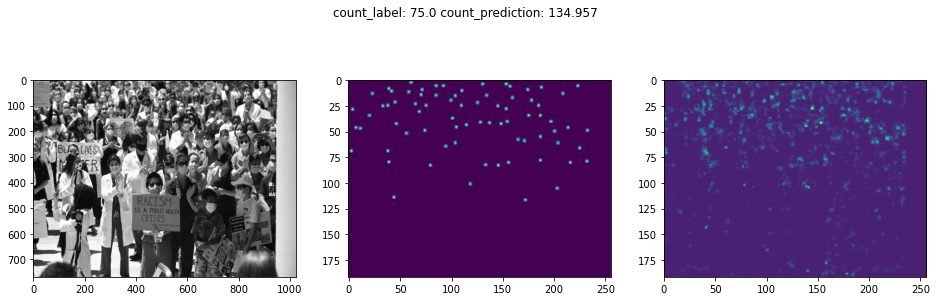

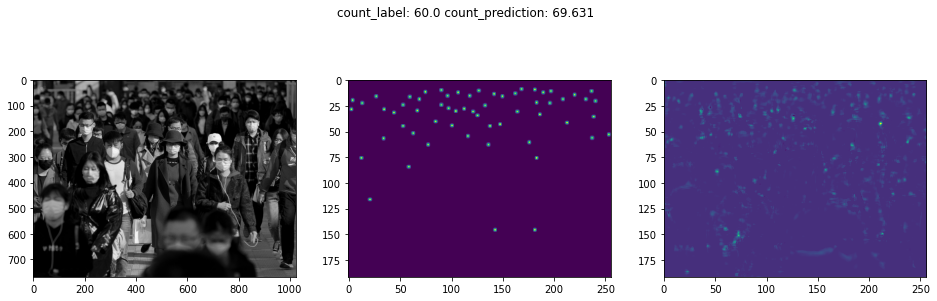

MAE: 36.13 RMSE: 43.98


In [4]:
weights_path = f'./weights/mae_36.13_mcnn_base_shhb_val.hdf5'
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

first_predictions(validation_img, validation_labels, model, 2)
calc_mae_mse(validation_img, validation_labels, model)

## Unfreeze all layers

In [5]:
weights_path = f'./weights/mae_36.13_mcnn_base_shhb_val.hdf5'
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})
# =================================================================
# CONFIG
# =================================================================
model_name = 'test'
submodel_name = ''
dataset = ''
epochs = 50
batch_size = 50
# =================================================================

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)

weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=0, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(
    log_dir='./exp/'+f"{datetime.now().strftime('%Y%m%d_%H:%M')}_{model_name}_{submodel_name}_{dataset}_all"
)

model._get_distribution_strategy = lambda: None
adam = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[monitor_mae, monitor_mse])

In [6]:
# if os.path.exists('./exp/'):
#     shutil.rmtree('./exp/')
#     os.makedirs('./exp/')
    
if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

# Training
model._get_distribution_strategy = lambda: None
history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs, shuffle= True,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val, checkpointer_best_train, checkpointer_tensorboard],
    verbose=0
)

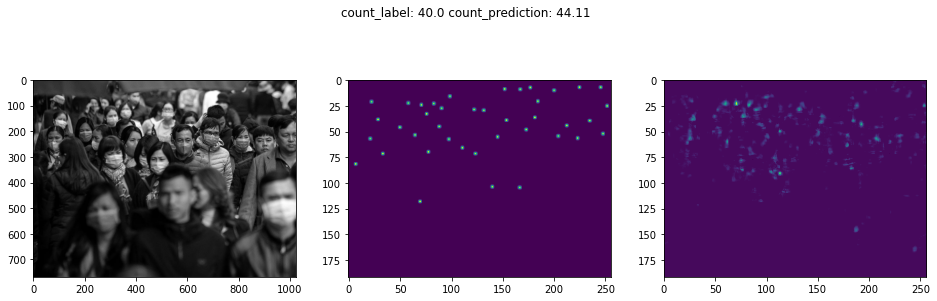

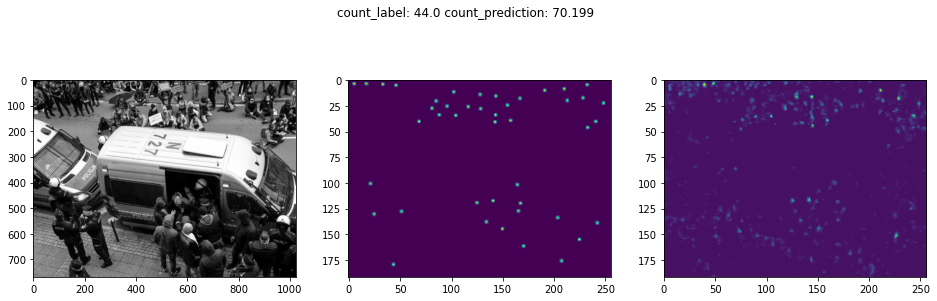

MAE: 12.68 RMSE: 17.34


In [10]:
weights_path = f'./weights/test___val.hdf5'  # {test___val,
                                                        #  test___train}
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

sample_predictions(validation_img, validation_labels, model, 2)
calc_mae_mse(validation_img, validation_labels, model)